In [30]:
# 1) Setup & imports
import os
from datetime import timedelta
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Display settings
pd.options.display.max_columns = 200
pd.options.display.width = 160

# Paths - adjust if needed
RAW_PATH = "/content/index.csv"     # <-- change if your CSV is elsewhere
CLEANED_PATH = "/mnt/data/cleaned_coffee_sales.csv"
FORECAST_PATH = "/mnt/data/next7day_forecast.csv"
DB_PATH = "/mnt/data/coffee_sales.db"
SQL_FILE_PATH = "/mnt/data/coffee_sales_queries.sql"
DAILY_AGG_PATH = "/mnt/data/daily_aggregates.csv"
NOTEBOOK_SAVE_PATH = "/mnt/data/coffee_sales_full_notebook.ipynb"

print('Notebook started at:', pd.Timestamp.now())


Notebook started at: 2025-09-06 07:32:48.128543


In [31]:
# 2) Load data
if not os.path.exists(RAW_PATH):
    raise FileNotFoundError(f"{RAW_PATH} not found. Upload your CSV to that path or update RAW_PATH.")

df = pd.read_csv(RAW_PATH)
print('Original columns:', df.columns.tolist())

# Standardize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
print('Standardized columns:', df.columns.tolist())

# Quick peek
df.head(5)


Original columns: ['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name']
Standardized columns: ['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name']


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [32]:
# 3) Data cleaning & feature engineering

# Coerce date/datetime and numeric money
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
if 'money' in df.columns:
    df['money'] = pd.to_numeric(df['money'], errors='coerce')

# Drop rows missing essential info
before = len(df)
df = df.dropna(subset=['date', 'money', 'coffee_name'])
after = len(df)
print(f'Dropped {before-after} rows missing critical info. Remaining rows: {after}')

# Fill categorical nulls with 'Unknown'
for c in ['cash_type', 'card', 'coffee_name']:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')

# Add calendar features
df['month'] = df['date'].dt.to_period('M').astype(str)
df['weekday'] = df['date'].dt.day_name()
df['hour'] = df['datetime'].dt.hour if 'datetime' in df.columns else np.nan

# Remove duplicates
dups = df.duplicated().sum()
print('Duplicate rows:', dups)
df = df.drop_duplicates()

# Clip 'money' by IQR to limit extreme outliers (but keep original money column)
q1, q3 = df['money'].quantile([0.25,0.75])
iqr = q3 - q1
low, high = q1 - 3*iqr, q3 + 3*iqr
df['money_clipped'] = df['money'].clip(lower=low, upper=high)

# Save cleaned file
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(CLEANED_PATH), exist_ok=True)
df.to_csv(CLEANED_PATH, index=False)
print('Cleaned CSV saved to:', CLEANED_PATH)

# Show cleaned snapshot
display(df[['date','datetime','cash_type','card','money','money_clipped','coffee_name','month','weekday','hour']].head())

Dropped 0 rows missing critical info. Remaining rows: 1133
Duplicate rows: 0
Cleaned CSV saved to: /mnt/data/cleaned_coffee_sales.csv


,date,datetime,cash_type,card,money,money_clipped,coffee_name,month,weekday,hour
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,38.7,Latte,2024-03,Friday,10
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,38.7,Hot Chocolate,2024-03,Friday,12
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,38.7,Hot Chocolate,2024-03,Friday,12
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,28.9,Americano,2024-03,Friday,13
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,38.7,Latte,2024-03,Friday,13


Top products by revenue:


,coffee_name,money_clipped
7,Latte,9009.14
1,Americano with Milk,8601.94
2,Cappuccino,7333.14
0,Americano,4644.54
6,Hot Chocolate,2778.48
4,Cortado,2745.08
3,Cocoa,1295.94
5,Espresso,1100.62



Top products by count:


,coffee_name,size
1,Americano with Milk,268
7,Latte,243
2,Cappuccino,196
0,Americano,169
4,Cortado,99
6,Hot Chocolate,74
5,Espresso,49
3,Cocoa,35


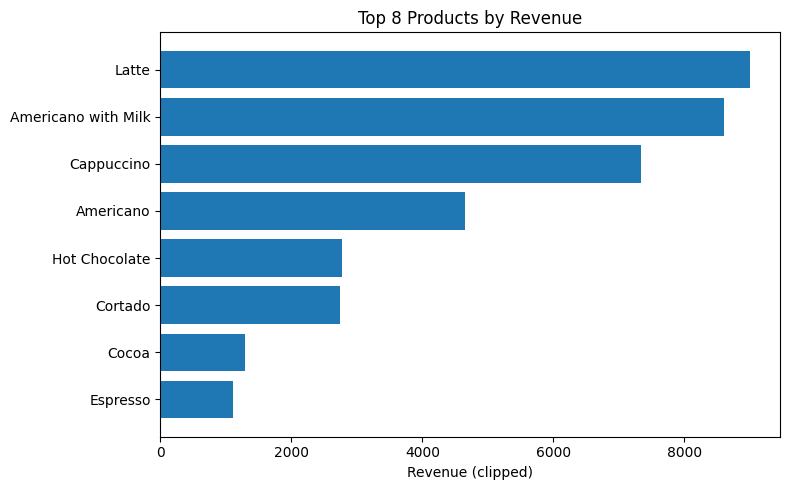

In [33]:
# 4) EDA - product popularity and revenue

# Top products by revenue and by count
top_rev = df.groupby('coffee_name', as_index=False)['money_clipped'].sum().sort_values('money_clipped', ascending=False)
top_count = df.groupby('coffee_name', as_index=False).size().sort_values('size', ascending=False)

print('Top products by revenue:')
display(top_rev.head(10))

print('\nTop products by count:')
display(top_count.head(10))

# Plot top products by revenue (top 8)
plt.figure(figsize=(8,5))
plt.barh(top_rev['coffee_name'].head(8), top_rev['money_clipped'].head(8))
plt.xlabel('Revenue (clipped)')
plt.title('Top 8 Products by Revenue')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


,month,txns
0,2024-03,206
1,2024-04,196
2,2024-05,267
3,2024-06,227
4,2024-07,237


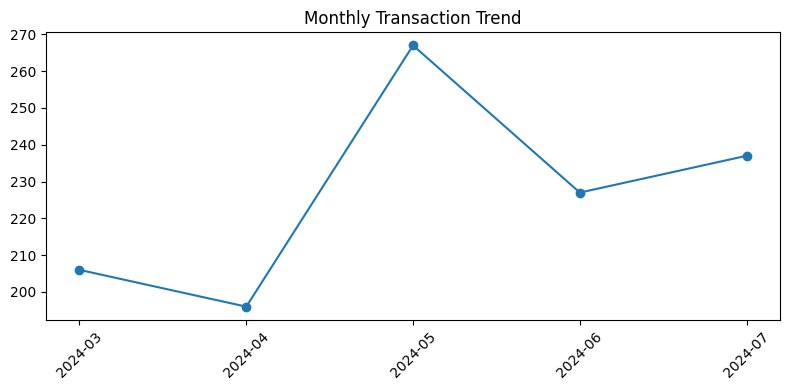

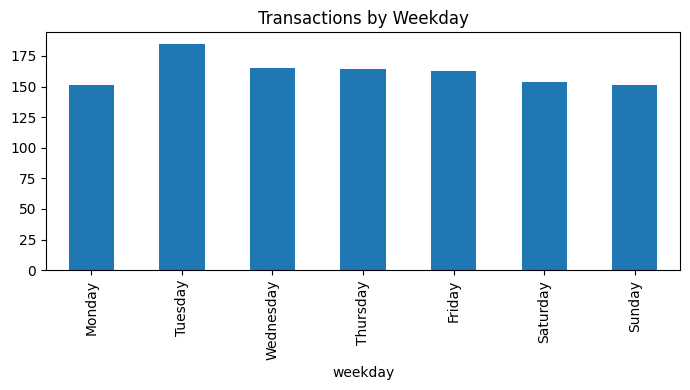

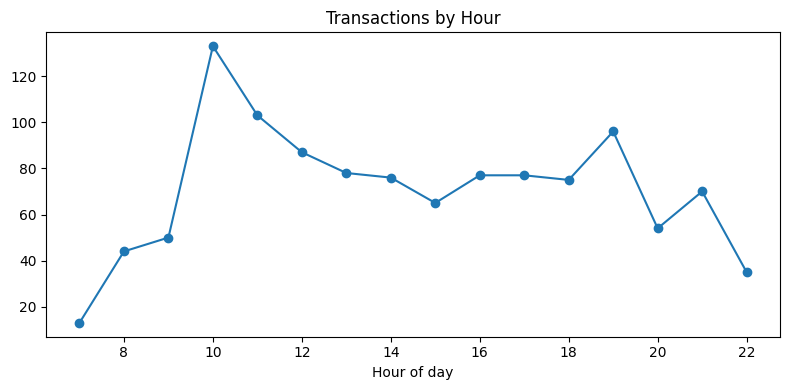

In [34]:
# 4b) Time trends: monthly, weekday, hourly

# Monthly trend (transaction counts)
monthly = df.groupby('month').size().reset_index(name='txns').sort_values('month')
display(monthly)

plt.figure(figsize=(8,4))
plt.plot(monthly['month'], monthly['txns'], marker='o')
plt.title('Monthly Transaction Trend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Weekday trend
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_cnt = df.groupby('weekday').size().reindex(weekday_order, fill_value=0)
plt.figure(figsize=(7,4))
weekday_cnt.plot(kind='bar')
plt.title('Transactions by Weekday')
plt.tight_layout()
plt.show()

# Hourly trend (if hour column exists)
if df['hour'].notna().any():
    hour_cnt = df.dropna(subset=['hour']).groupby('hour').size().reset_index(name='txns').sort_values('hour')
    plt.figure(figsize=(8,4))
    plt.plot(hour_cnt['hour'], hour_cnt['txns'], marker='o')
    plt.title('Transactions by Hour')
    plt.xlabel('Hour of day')
    plt.tight_layout()
    plt.show()
else:
    print('No datetime/hour data available to show hourly trends.')


coffee_name,Americano,Americano with Milk,Cappuccino,Cocoa,Cortado,Espresso,Hot Chocolate,Latte
month,,,,,,,,
2024-03,36,34,20,6,30,10,22,48
2024-04,35,42,43,6,19,7,13,31
2024-05,48,58,55,9,17,8,14,58
2024-06,14,69,46,5,19,10,14,50
2024-07,36,65,32,9,14,14,11,56


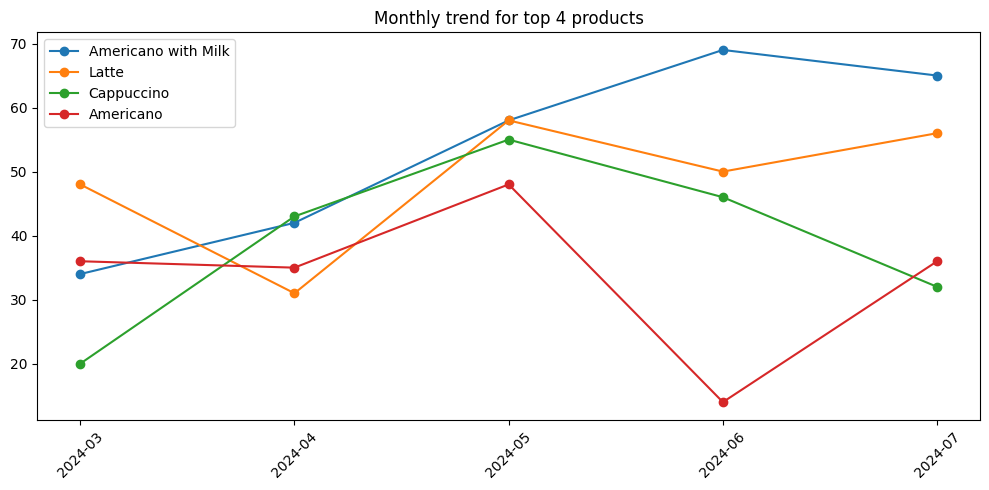

In [35]:
# 4c) Product-level monthly counts pivot (good for product demand)
product_monthly = df.groupby(['month','coffee_name']).size().unstack(fill_value=0)
display(product_monthly.head())

# Plot top 4 products monthly trend
top4 = top_count['coffee_name'].head(4).tolist()
plt.figure(figsize=(10,5))
for p in top4:
    if p in product_monthly.columns:
        plt.plot(product_monthly.index, product_monthly[p], marker='o', label=p)
plt.title('Monthly trend for top 4 products')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
# 5) Time-series prep - daily aggregates
daily = (
    df.groupby('date')
      .agg(transactions=('coffee_name','count'),
           revenue=('money_clipped','sum'))
      .reset_index()
      .sort_values('date')
)

# calendar features and lags
daily['dow'] = daily['date'].dt.dayofweek  # Monday=0
for lag in [1,7]:
    daily[f'lag_{lag}'] = daily['transactions'].shift(lag)

display(daily.head(10))

# Save daily snapshot
daily.to_csv(DAILY_AGG_PATH, index=False)
print('Daily aggregates saved to', DAILY_AGG_PATH)


,date,transactions,revenue,dow,lag_1,lag_7
0,2024-03-01,11,396.3,4,NaN,NaN
1,2024-03-02,7,228.1,5,11.0,NaN
2,2024-03-03,10,349.1,6,7.0,NaN
3,2024-03-04,4,135.2,0,10.0,NaN
4,2024-03-05,9,338.5,1,4.0,NaN
5,2024-03-06,5,170.2,2,9.0,NaN
6,2024-03-07,6,220.1,3,5.0,NaN
7,2024-03-08,8,265.5,4,6.0,11.0
8,2024-03-09,14,479.4,5,8.0,7.0
9,2024-03-10,7,231.6,6,14.0,10.0


Daily aggregates saved to /mnt/data/daily_aggregates.csv


In [37]:
# 6) Modeling - next-day transactions (Linear Regression using lags + dow)
model_df = daily.dropna().copy()
if len(model_df) < 8:
    print('Warning: not enough rows after creating lags. Model may be unreliable.')

# Train/test split: last 14 or ~20% as test
test_horizon = min(14, max(1, len(model_df)//5))
train_df = model_df.iloc[:-test_horizon].copy()
test_df = model_df.iloc[-test_horizon:].copy()

X_train = train_df[['dow','lag_1','lag_7']]
y_train = train_df['transactions']
X_test = test_df[['dow','lag_1','lag_7']]
y_test = test_df['transactions']

lin = LinearRegression()
lin.fit(X_train, y_train)
pred_test = lin.predict(X_test)

# Baseline: 7-day moving average
def moving_average_forecast(series, window=7):
    preds = []
    for i in range(len(series)):
        if i < window:
            preds.append(series[:i+1].mean())
        else:
            preds.append(series[i-window:i].mean())
    return np.array(preds)

baseline = moving_average_forecast(model_df['transactions'].values, 7)[-test_horizon:]

print('Test MAE (LinearReg):', mean_absolute_error(y_test, pred_test))
print('Test R2  (LinearReg):', r2_score(y_test, pred_test))
print('Test MAE (Baseline 7-day MA):', mean_absolute_error(y_test, baseline))


Test MAE (LinearReg): 5.158413068820031
Test R2  (LinearReg): -0.20778880735024363
Test MAE (Baseline 7-day MA): 5.163265306122449


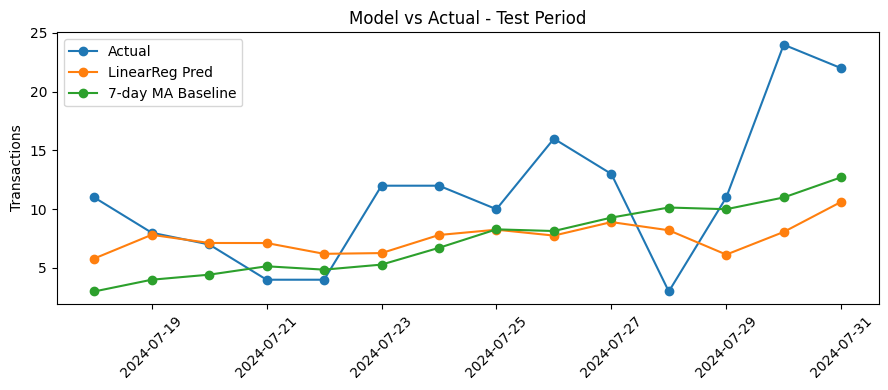

In [38]:
# Plot predictions vs actual for test period
plt.figure(figsize=(9,4))
plt.plot(test_df['date'], test_df['transactions'].values, marker='o', label='Actual')
plt.plot(test_df['date'], pred_test, marker='o', label='LinearReg Pred')
plt.plot(test_df['date'], baseline, marker='o', label='7-day MA Baseline')
plt.xticks(rotation=45)
plt.ylabel('Transactions')
plt.title('Model vs Actual - Test Period')
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
# 7) Forecast next 7 days (recursive using linear model)
recent_transactions = list(model_df['transactions'].values)
current_date = daily['date'].max()
future_rows = []
for i in range(1,8):
    fdate = current_date + timedelta(days=i)
    dow = fdate.dayofweek
    lag1 = recent_transactions[-1]
    lag7 = recent_transactions[-7] if len(recent_transactions) >= 7 else recent_transactions[-1]
    # Create a DataFrame with feature names for prediction
    X_f = pd.DataFrame([[dow, lag1, lag7]], columns=['dow', 'lag_1', 'lag_7'])
    pred = float(lin.predict(X_f)[0])
    pred = max(0, pred)
    recent_transactions.append(pred)
    future_rows.append({'date': fdate, 'pred_transactions': pred})

forecast_df = pd.DataFrame(future_rows)
forecast_df.to_csv(FORECAST_PATH, index=False)
print('Next 7 days forecast saved to', FORECAST_PATH)
display(forecast_df)

Next 7 days forecast saved to /mnt/data/next7day_forecast.csv


,date,pred_transactions
0,2024-08-01,10.167290
1,2024-08-02,8.132862
2,2024-08-03,7.625445
3,2024-08-04,7.114806
4,2024-08-05,7.243128
5,2024-08-06,7.847829
6,2024-08-07,7.899256


In [40]:
# 8) Product-level analysis: times and revenue share
prod_summary = df.groupby('coffee_name').agg(transactions=('coffee_name','count'), revenue=('money_clipped','sum')).sort_values('transactions', ascending=False)
prod_summary['revenue_share'] = prod_summary['revenue'] / prod_summary['revenue'].sum()
display(prod_summary.head(20))

# Peak hour per product (if hour data exists)
if df['hour'].notna().any():
    peak_hour = df.groupby(['coffee_name','hour']).size().reset_index(name='count').sort_values(['coffee_name','count'], ascending=[True, False])
    peak = peak_hour.groupby('coffee_name').first().reset_index().sort_values('count', ascending=False)
    display(peak.head(20))
else:
    print('No hourly data to compute peak hour by product.')


,transactions,revenue,revenue_share
coffee_name,,,
Americano with Milk,268,8601.94,0.229331
Latte,243,9009.14,0.240187
Cappuccino,196,7333.14,0.195504
Americano,169,4644.54,0.123825
Cortado,99,2745.08,0.073185
Hot Chocolate,74,2778.48,0.074075
Espresso,49,1100.62,0.029343
Cocoa,35,1295.94,0.034550


,coffee_name,hour,count
7,Latte,10,51
2,Cappuccino,19,34
1,Americano with Milk,10,31
0,Americano,11,21
4,Cortado,11,13
6,Hot Chocolate,18,10
3,Cocoa,20,6
5,Espresso,11,6


In [41]:
# 9) SQL integration - Save cleaned dataframe to SQLite and create SQL query file
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)
conn = sqlite3.connect(DB_PATH)
tmp = df.copy()
if 'datetime' in tmp.columns:
    tmp['datetime'] = tmp['datetime'].astype(str)
tmp.to_sql('coffee_sales', conn, index=False)
print('SQLite DB saved to:', DB_PATH)

queries = {
    'top_products_by_revenue': """SELECT coffee_name, ROUND(SUM(money_clipped),2) as revenue
FROM coffee_sales
GROUP BY coffee_name
ORDER BY revenue DESC
LIMIT 10;""",

    'peak_hours': """SELECT hour, COUNT(*) as txns
FROM coffee_sales
WHERE hour IS NOT NULL
GROUP BY hour
ORDER BY txns DESC
LIMIT 10;""",

    'weekday_mix': """SELECT weekday, COUNT(*) as txns, ROUND(SUM(money_clipped),2) as revenue
FROM coffee_sales
GROUP BY weekday
ORDER BY txns DESC;""",

    'monthly_trend': """SELECT month, COUNT(*) as txns, ROUND(SUM(money_clipped),2) as revenue
FROM coffee_sales
GROUP BY month
ORDER BY month;""",

    'cash_vs_card': """SELECT cash_type, COUNT(*) as txns, ROUND(SUM(money_clipped),2) as revenue
FROM coffee_sales
GROUP BY cash_type
ORDER BY revenue DESC;"""
}

with open(SQL_FILE_PATH, 'w') as f:
    for name,q in queries.items():
        f.write(f"-- {name}\n{q}\n\n")

print('SQL queries saved to:', SQL_FILE_PATH)

# Example: run one query and show top 10 revenue products
display(pd.read_sql_query(queries['top_products_by_revenue'], conn).head(10))

conn.close()


SQLite DB saved to: /mnt/data/coffee_sales.db
SQL queries saved to: /mnt/data/coffee_sales_queries.sql


,coffee_name,revenue
0,Latte,9009.14
1,Americano with Milk,8601.94
2,Cappuccino,7333.14
3,Americano,4644.54
4,Hot Chocolate,2778.48
5,Cortado,2745.08
6,Cocoa,1295.94
7,Espresso,1100.62


In [42]:
# app_streamlit.py (save separately and run with `streamlit run app_streamlit.py`)
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

CLEANED = "/mnt/data/cleaned_coffee_sales.csv"

st.set_page_config(page_title="Coffee Sales Dashboard", layout="wide")
st.title("Coffee Sales - Interactive Dashboard")

@st.cache_data
def load_data(path):
    df = pd.read_csv(path, parse_dates=["date"])
    return df

df = load_data(CLEANED)

st.sidebar.header("Filters")
prod_opt = st.sidebar.multiselect("Coffee product", options=df["coffee_name"].unique(), default=df["coffee_name"].unique())
date_min, date_max = st.sidebar.date_input("Date range", [df["date"].min(), df["date"].max()])

mask = (df["coffee_name"].isin(prod_opt)) & (df["date"].between(pd.to_datetime(date_min), pd.to_datetime(date_max)))
df_f = df.loc[mask].copy()

st.metric("Total transactions", len(df_f))
st.metric("Total revenue", f"{df_f['money_clipped'].sum():.2f}")

st.header("Revenue by Product")
rev_by_prod = df_f.groupby("coffee_name")["money_clipped"].sum().sort_values(ascending=False)
fig, ax = plt.subplots()
rev_by_prod.plot(kind="bar", ax=ax)
ax.set_ylabel("Revenue")
st.pyplot(fig)

st.header("Transactions by Weekday")
wk = df_f.groupby("weekday").size().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], fill_value=0)
fig2, ax2 = plt.subplots()
wk.plot(kind="bar", ax=ax2)
st.pyplot(fig2)

st.header("Raw data (filtered)")
st.dataframe(df_f.reset_index(drop=True))


2025-09-06 07:32:51.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 07:32:51.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 07:32:51.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 07:32:51.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 07:32:51.227 No runtime found, using MemoryCacheStorageManager
2025-09-06 07:32:51.230 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 07:32:51.231 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 07:32:51.232 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 07:32:51.234 Thread 'MainThread':

DeltaGenerator()

In [43]:
%pip install streamlit

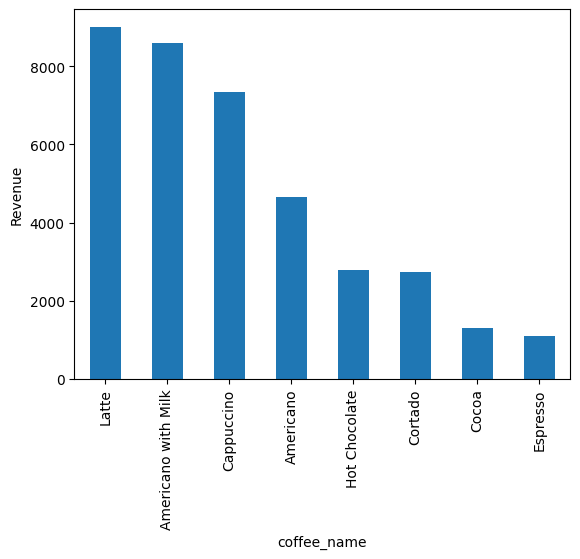

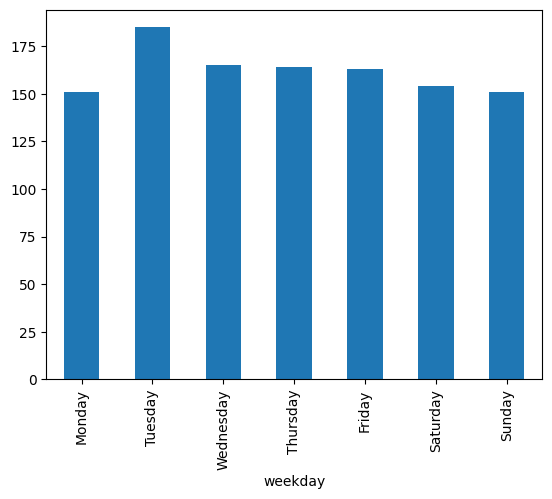

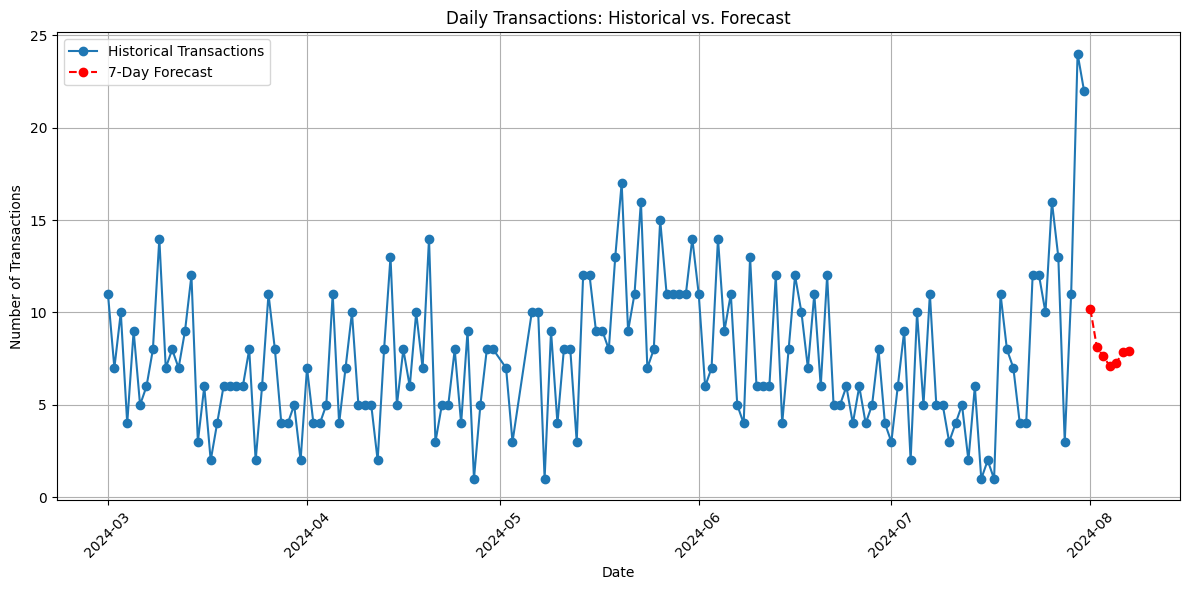

In [44]:
# Visualize historical transactions and forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(daily['date'], daily['transactions'], marker='o', linestyle='-', label='Historical Transactions')

# Plot forecast data
plt.plot(forecast_df['date'], forecast_df['pred_transactions'], marker='o', linestyle='--', color='red', label='7-Day Forecast')

plt.title('Daily Transactions: Historical vs. Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()